In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, words
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
import os

In [ ]:
### Extraction Features

In [40]:
# Define the folder containing the processed CSV files
input_folder = "processed_data"

In [41]:
# Get the list of all CSV files in the folder
#csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]

# Create a dictionary to hold the DataFrames
#dfs = {}

# Loop through the files and create a DataFrame for each one
#for file in csv_files:
#    file_path = os.path.join(input_folder, file)
#    
#    # Load the CSV into a DataFrame
#    df = pd.read_csv(file_path)
#    
#    # Add the DataFrame to the dictionary using the filename (without extension) as the key
#    dfs[file] = df
#
#    print(f"Created DataFrame for file: {file}")

In [42]:
#dfs["Resume_processed_remove_numbers=False_use_dictionary=True_use_lemmatization=False_use_stemming=False.csv"].head()

In [43]:
df = pd.read_csv("processed_data/Resume_proc_stem.csv")

In [44]:
# Get a list of stop word
stop_words = set(nltk.corpus.stopwords.words('english'))

count_vect = CountVectorizer(
    lowercase=True,
    binary = False,
    max_features = 10000,
    stop_words = list(stop_words),        # TODO could be not useful, we already remove stop words in preprocess_text
    ngram_range=(1,6),                    # Considers unigrams and bigrams
    max_df = 0.8,                           # Ignores words appearing in more than 85% of documents (too common)
    min_df = 2                              # Keeps words appearing in at least 2 documents (filters rare words)
)

In [45]:
# Split data into training and validation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['Resume_str'], df['Category'], test_size=0.2, random_state=42, stratify=df['Category'])


# Print the sizes of the split datasets
print("Train data size:", X_train.shape)
print("Validation data size:", X_test.shape)

Train data size: (1986,)
Validation data size: (497,)


In [46]:
conuntvectorizer_train = count_vect.fit_transform(X_train).astype(float)
conuntvectorizer_test = count_vect.transform(X_test).astype(float)

In [47]:
len(count_vect.vocabulary_)

10000

In [48]:
#tfidf_transformer = TfidfTransformer()

In [49]:
#X_train_tfidf = tfidf_transformer.fit_transform(conuntvectorizer_train)
#X_test_tfidf = tfidf_transformer.transform(conuntvectorizer_test)

In [50]:
#smote = SMOTE(sampling_strategy='auto', random_state=42)
#X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)

# using grid search for find optimal values for RF classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

RFC = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

grid = GridSearchCV(estimator=RFC, param_grid=param_grid, cv= 5, scoring='accuracy', return_train_score=False, verbose=1)
grid_search = grid.fit(X_train_tfidf, y_train)

print(grid_search.best_params_)

In [51]:
from sklearn.ensemble import RandomForestClassifier

RF_Model = RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators= 500, max_depth=8, criterion='gini')
RF_Model.fit(conuntvectorizer_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=500, random_state=42)

In [52]:
prediction=RF_Model.predict(conuntvectorizer_test)
prediction

array(['DESIGNER', 'DIGITAL-MEDIA', 'TEACHER', 'HEALTHCARE',
       'CONSTRUCTION', 'HR', 'BANKING', 'PUBLIC-RELATIONS', 'CONSULTANT',
       'DIGITAL-MEDIA', 'DIGITAL-MEDIA', 'ADVOCATE', 'HEALTHCARE',
       'ADVOCATE', 'ENGINEERING', 'CONSTRUCTION', 'AVIATION', 'FINANCE',
       'INFORMATION-TECHNOLOGY', 'ENGINEERING', 'TEACHER',
       'PUBLIC-RELATIONS', 'HR', 'SALES', 'ACCOUNTANT', 'FINANCE',
       'BUSINESS-DEVELOPMENT', 'FINANCE', 'ADVOCATE', 'PUBLIC-RELATIONS',
       'ENGINEERING', 'FITNESS', 'PUBLIC-RELATIONS', 'CHEF', 'ACCOUNTANT',
       'DESIGNER', 'TEACHER', 'BUSINESS-DEVELOPMENT', 'ENGINEERING',
       'SALES', 'CONSTRUCTION', 'FITNESS', 'DESIGNER',
       'BUSINESS-DEVELOPMENT', 'TEACHER', 'INFORMATION-TECHNOLOGY',
       'PUBLIC-RELATIONS', 'PUBLIC-RELATIONS', 'ACCOUNTANT',
       'CONSTRUCTION', 'DESIGNER', 'FINANCE', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'ENGINEERING', 'ACCOUNTANT', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'ADVOCATE', 'ACCOUNTANT',
       'BU

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_test,prediction))        #TODO TOGLIERE zero_division=0

                        precision    recall  f1-score   support

            ACCOUNTANT       0.49      0.96      0.65        24
              ADVOCATE       0.80      0.83      0.82        24
           AGRICULTURE       0.00      0.00      0.00        13
               APPAREL       1.00      0.37      0.54        19
                  ARTS       1.00      0.05      0.09        21
            AUTOMOBILE       0.00      0.00      0.00         7
              AVIATION       0.81      0.88      0.84        24
               BANKING       0.77      0.43      0.56        23
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.79      0.96      0.87        24
                  CHEF       0.87      0.83      0.85        24
          CONSTRUCTION       0.89      0.77      0.83        22
            CONSULTANT       0.81      0.57      0.67        23
              DESIGNER       0.90      0.86      0.88        21
         DIGITAL-MEDIA       0.90      

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [54]:
print("training Score: {:.2f}".format(RF_Model.score(conuntvectorizer_train, y_train)))
print("test Score: {:.2f}".format(RF_Model.score(conuntvectorizer_test, y_test)))

training Score: 0.87
test Score: 0.70


<Figure size 1500x1000 with 0 Axes>

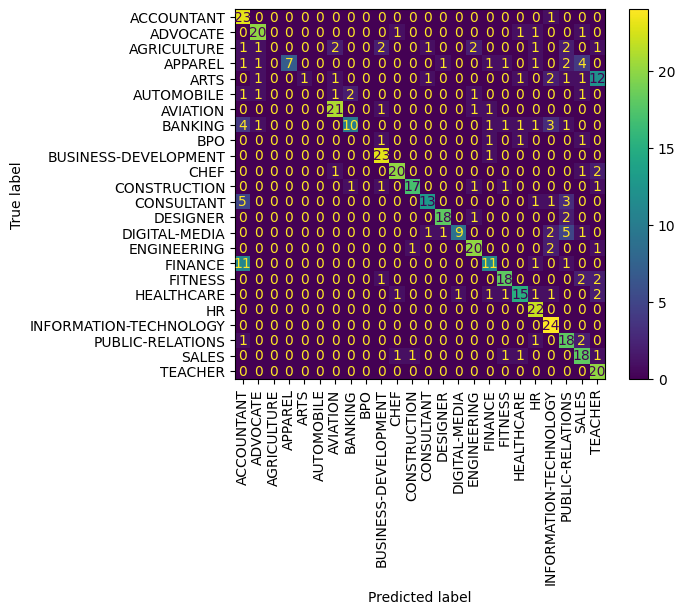

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay
plt.figure(figsize=(15, 10))  # Imposta la dimensione della figura
ConfusionMatrixDisplay.from_predictions(y_test, prediction)
plt.xticks(rotation=90)
plt.show()

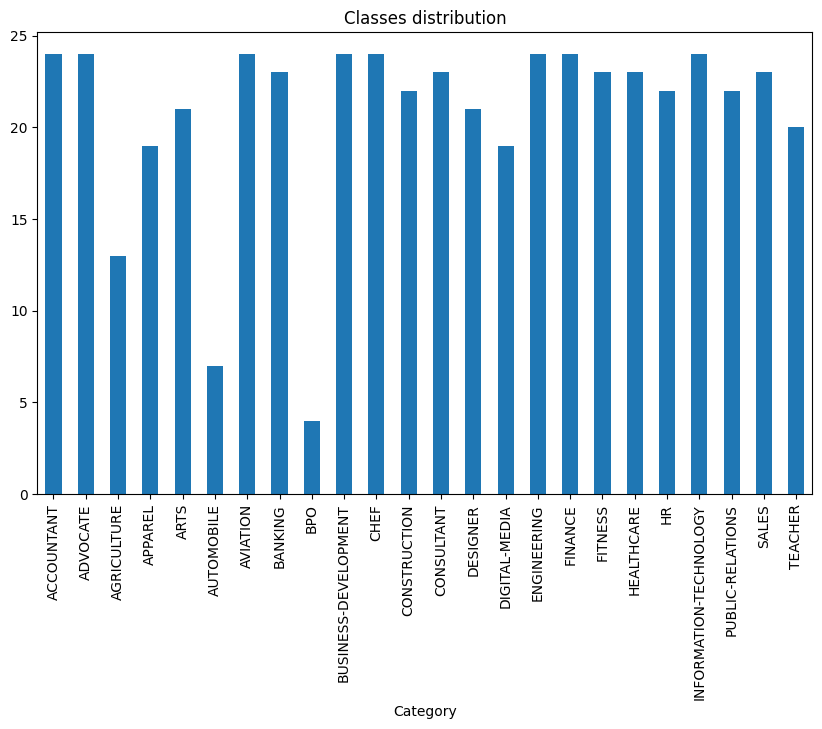

In [56]:
y_test.value_counts().sort_index().plot(kind='bar', title='Classes distribution', figsize=(10,6))
plt.show()